In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

In [ ]:
def evaluate_model(model, X, y):
    """Evaluate the model on the given data."""
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
    metrics = {
        'accuracy': accuracy_score(y, predictions),
        'precision': precision_score(y, predictions),
        'recall': recall_score(y, predictions),
        'f1': f1_score(y, predictions),
        'roc_auc': roc_auc_score(y, probabilities) if probabilities is not None else 'N/A'
    }
    return metrics
def transform_splits(vectorizer, train_data, validation_data, test_data):
    """Transform the splits using the vectorizer."""
    X_train = vectorizer.transform(train_data['message'])
    X_validation = vectorizer.transform(validation_data['message'])
    X_test = vectorizer.transform(test_data['message'])

    y_train = train_data['label']
    y_validation = validation_data['label']
    y_test = test_data['label']


    return X_train, X_validation, X_test, y_train, y_validation, y_test


In [ ]:
train_data=pd.read_csv('/content/train .csv')
test_data=pd.read_csv('/content/test .csv')
validation_data=pd.read_csv('/content/validation .csv')

In [ ]:
train_data.head()

,label,message
0,1,INTERFLORA - It's not too late to order Inter...
1,0,I dunno lei... Like dun haf...
2,0,"Poyyarikatur,kolathupalayam,unjalur post,erode..."
3,0,"Yeah, I'll leave in a couple minutes &amp; let..."
4,0,meet you in corporation st outside gap … you c...


In [ ]:
test_data.head()

,label,message
0,0,PISS IS TALKING IS SOMEONE THAT REALISE U THAT...
1,0,I'm e person who's doing e sms survey...
2,0,Oh thanks a lot..i already bought 2 eggs ..
3,0,"Yeah sure, give me a couple minutes to track d..."
4,0,Good Morning my Dear........... Have a great &...


In [ ]:
validation_data.head()

,label,message
0,0,:( but your not here....
1,0,"Haha better late than ever, any way I could sw..."
2,0,Finally it has happened..! Aftr decades..! BEE...
3,0,I only haf msn. It's yijue@hotmail.com
4,0,Dont think you need yellow card for uk travel....


In [ ]:
with open('/content/tfidf_vectorizer .pkl', 'rb') as file:
    vectorizer = pickle.load(file)

X_train, X_validation, X_test, y_train, y_validation, y_test = transform_splits(vectorizer, train_data, validation_data, test_data)



Logistic Regression Model

In [ ]:
def train_logistic_regression_on_train_data(X_train, y_train):
    """Train a weighted Logistic Regression model on training data."""
    model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    # Compute sample weights for class balancing(As it seems to be an imbalanced data set)
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    return model

def fine_tune_with_validation(model, X_validation, y_validation):
    """Fine-tune Logistic Regression using validation data."""
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2'],
    }

    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1)
    grid_search.fit(X_validation, y_validation)

    best_model = grid_search.best_estimator_
    print("Best Parameters from Validation Data:", grid_search.best_params_)
    print("Best Validation F1-Score:", grid_search.best_score_)

    return best_model

def evaluate_on_test(best_model, X_test, y_test):
    """Evaluate the best model on the test data."""
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None
    test_metrics = {
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1-Score": f1_score(y_test, y_test_pred),
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "ROC AUC": roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else 'N/A',
    }
    print("Test Metrics:", test_metrics)
    return test_metrics

# Train the Logistic Regression model on training data
trained_logistic_model = train_logistic_regression_on_train_data(X_train, y_train)

# Fine-tune the model using validation data
best_logistic_model = fine_tune_with_validation(trained_logistic_model, X_validation, y_validation)

# Evaluate the best Logistic Regression model on the test data
test_metrics = evaluate_on_test(best_logistic_model, X_test, y_test)

Best Parameters from Validation Data: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Validation F1-Score: 0.856537571069576
Test Metrics: {'Precision': 0.8928571428571429, 'Recall': 0.8333333333333334, 'F1-Score': 0.8620689655172413, 'Accuracy': 0.9641255605381166, 'ROC AUC': 0.9858445595854922}


Adaboost classifier

In [ ]:
def train_adaboost_on_train_data(X_train, y_train):
    """Train a weighted AdaBoost Classifier on training data."""
    base_estimator = DecisionTreeClassifier(max_depth=1)
    model = AdaBoostClassifier(estimator=base_estimator, random_state=42)
    # Compute sample weights for class balancing(As it seems to be an imbalanced data set)
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    return model



def fine_tune_with_validation(model, X_validation, y_validation):
    """Fine-tune AdaBoost Classifier using validation data."""
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1, 10],
        'estimator__max_depth': [1, 2, 3],
    }

    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1)
    grid_search.fit(X_validation, y_validation)

    best_model = grid_search.best_estimator_
    print("Best Parameters from Validation Data:", grid_search.best_params_)
    print("Best Validation F1-Score:", grid_search.best_score_)

    return best_model



def evaluate_on_test(best_model, X_test, y_test):
    """Evaluate the best model on the test data."""
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None
    test_metrics = {
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1-Score": f1_score(y_test, y_test_pred),
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "ROC AUC": roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else 'N/A',
    }
    print("Test Metrics:", test_metrics)
    return test_metrics

# Train the AdaBoost model on training data
trained_adaboost_model = train_adaboost_on_train_data(X_train, y_train)

# Fine-tune the model using validation data
best_adaboost_model = fine_tune_with_validation(trained_adaboost_model, X_validation, y_validation)

# Evaluate the best AdaBoost model on the test data
test_metrics = evaluate_on_test(best_adaboost_model, X_test, y_test)


Best Parameters from Validation Data: {'estimator__max_depth': 3, 'learning_rate': 1, 'n_estimators': 100}
Best Validation F1-Score: 0.7697857054378794
Test Metrics: {'Precision': 0.9803921568627451, 'Recall': 0.6666666666666666, 'F1-Score': 0.7936507936507936, 'Accuracy': 0.9533632286995516, 'ROC AUC': 0.9586563039723661}


Random Forest Classifier

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight

def train_random_forest_on_train_data(X_train, y_train):
    """Train a weighted Random Forest model on training data."""
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    # Compute sample weights for class balancing(As it seems to be an imbalanced data set)
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    return model

def fine_tune_with_validation(model, X_validation, y_validation):
    """Fine-tune Random Forest using validation data."""
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1)
    grid_search.fit(X_validation, y_validation)

    best_model = grid_search.best_estimator_
    print("Best Parameters from Validation Data:", grid_search.best_params_)
    print("Best Validation F1-Score:", grid_search.best_score_)

    return best_model

def evaluate_on_test(best_model, X_test, y_test):
    """Evaluate the best model on the test data."""
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None
    test_metrics = {
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1-Score": f1_score(y_test, y_test_pred),
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "ROC AUC": roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else 'N/A',
    }
    print("Test Metrics:", test_metrics)
    return test_metrics

# Train the Random Forest model on training data
trained_random_forest_model = train_random_forest_on_train_data(X_train, y_train)

# Fine-tune the model using validation data
best_random_forest_model = fine_tune_with_validation(trained_random_forest_model, X_validation, y_validation)

# Evaluate the best Random Forest model on the test data
test_metrics = evaluate_on_test(best_random_forest_model, X_test, y_test)


Best Parameters from Validation Data: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Validation F1-Score: 0.8620157153770599
Test Metrics: {'Precision': 0.984251968503937, 'Recall': 0.8333333333333334, 'F1-Score': 0.9025270758122743, 'Accuracy': 0.9757847533632287, 'ROC AUC': 0.9855060449050086}


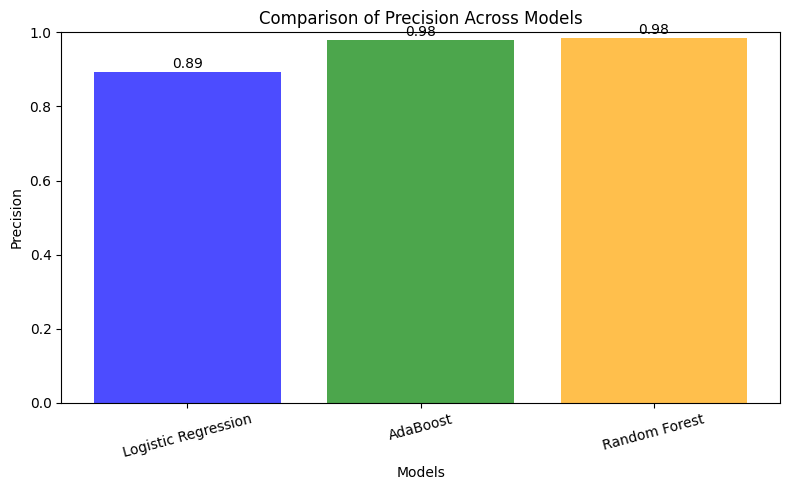

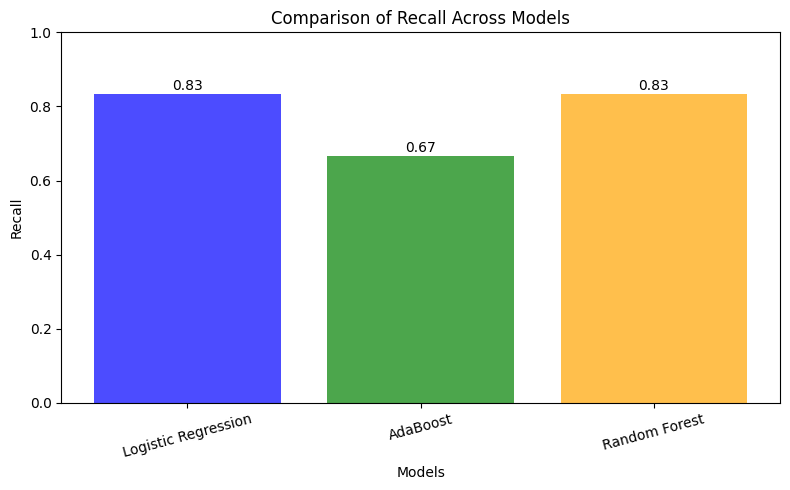

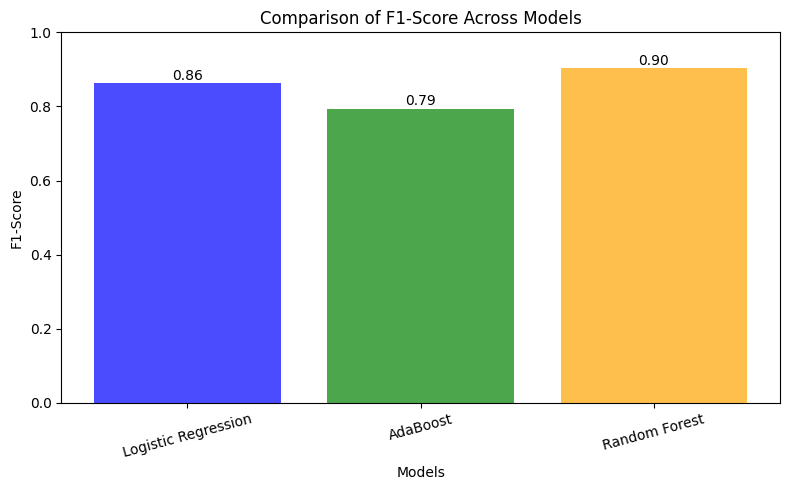

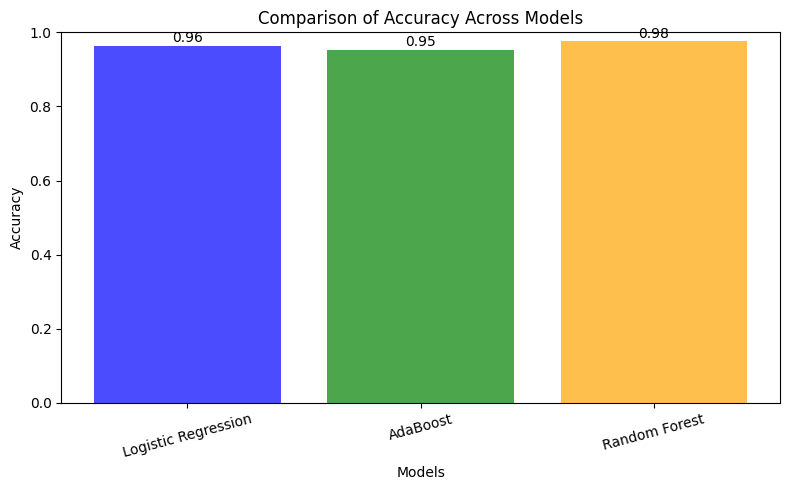

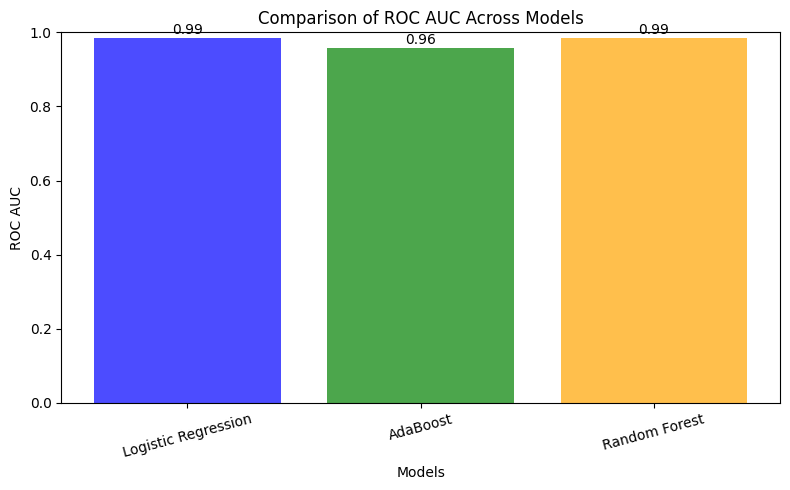

In [ ]:
import matplotlib.pyplot as plt

# Test metrics for Logistic Regression, AdaBoost, and Random Forest
models = ["Logistic Regression", "AdaBoost", "Random Forest"]
metrics_data = {
    "Precision": [0.8928571428571429, 0.9803921568627451, 0.984251968503937],
    "Recall": [0.8333333333333334, 0.6666666666666666, 0.8333333333333334],
    "F1-Score": [0.8620689655172413, 0.7936507936507936, 0.9025270758122743],
    "Accuracy": [0.9641255605381166, 0.9533632286995516, 0.9757847533632287],
    "ROC AUC": [0.9858445595854922, 0.9586563039723661, 0.9855060449050086]
}


for metric, values in metrics_data.items():
    plt.figure(figsize=(8, 5))
    plt.bar(models, values, color=['blue', 'green', 'orange'], alpha=0.7)
    plt.title(f"Comparison of {metric} Across Models")
    plt.ylabel(metric)
    plt.ylim(0, 1)  # Metrics are typically between 0 and 1
    plt.xlabel("Models")
    plt.xticks(rotation=15)
    for i, value in enumerate(values):
        plt.text(i, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()


## According to the evaluation metrics that we have computed for the three different models above, Random Forest model gives the best performance.